In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from pmdarima import ARIMA, auto_arima, model_selection
from sklearn.model_selection import ParameterGrid

In [2]:
path = '/home/mano/Manoj/Learning/time_series/data/time-series-analysis/Time Series Analysis/ARIMA, SARIMA and SARIMAX/daily_revenue.csv'

In [3]:
df = pd.read_csv(path, index_col='date', parse_dates=True, dayfirst=True)
df.head(10)

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%
2018-01-06,"6,095,418",25.02%,0.87%
2018-01-07,"7,661,844",25.33%,1.06%
2018-01-08,"7,036,112",24.83%,1.03%
2018-01-09,"7,100,900",25.11%,1.00%


In [4]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   revenue        1795 non-null   object
 1   discount_rate  1795 non-null   object
 2   coupon_rate    1795 non-null   object
dtypes: object(3)
memory usage: 56.1+ KB


revenue          0
discount_rate    0
coupon_rate      0
dtype: int64

In [5]:
df.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='date', length=1795, freq=None)

In [6]:
# Setting Frequency
df = df.asfreq('D')
df.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='date', length=1795, freq='D')

In [7]:
df.isnull().sum()

revenue          0
discount_rate    0
coupon_rate      0
dtype: int64

In [8]:
# Transform revenue into float
df['revenue'] = df['revenue'].str.replace(',', '').astype('float')

In [9]:
# Changing time series variable name
df = df.rename(columns={'revenue': 'y'})
df.head()

,y,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27%,1.09%
2018-01-02,8922076.0,30.87%,1.08%
2018-01-03,8446101.0,28.11%,1.01%
2018-01-04,7785798.0,27.32%,0.96%
2018-01-05,6375303.0,25.70%,0.90%


# Exploratory data analysis

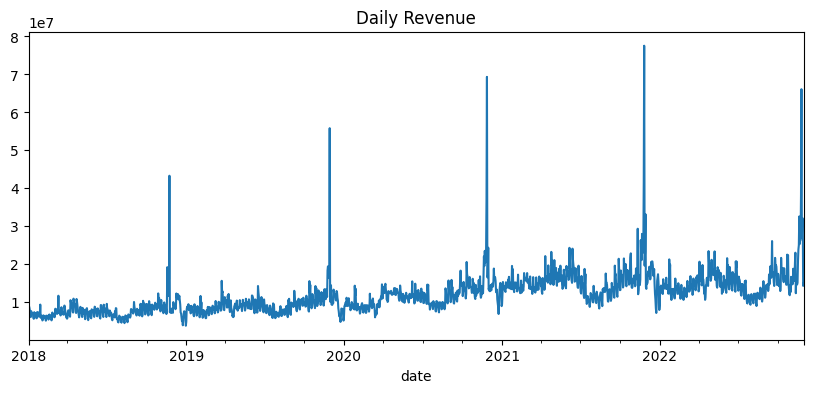

In [10]:
plt.figure(figsize=(10,4))
df['y'].plot(title="Daily Revenue")
plt.show()

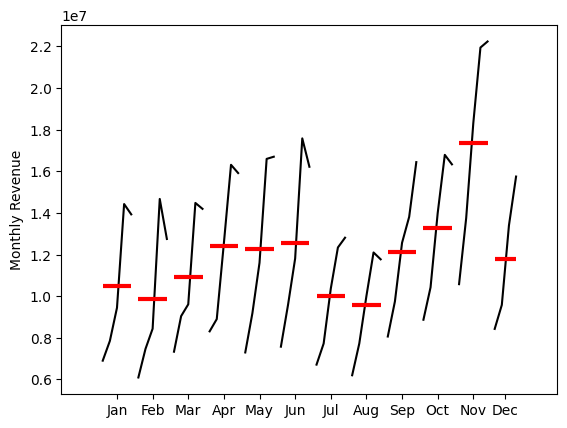

In [11]:
# Monthly revenue
month_plot(df['y'].resample('ME').mean(), ylabel="Monthly Revenue")
plt.show()


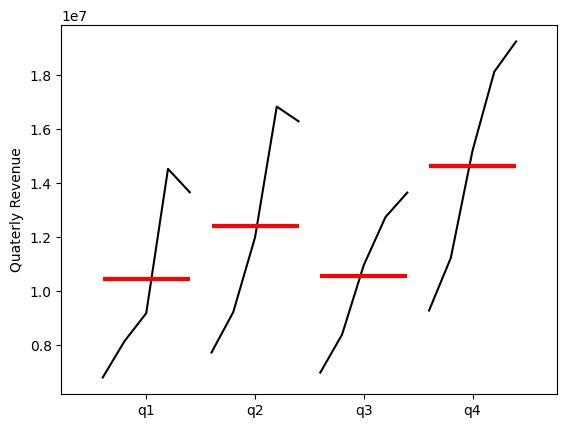

In [12]:
# Quaterly revenue
quarter_plot(df['y'].resample("QE").mean(), ylabel="Quaterly Revenue")
plt.show()

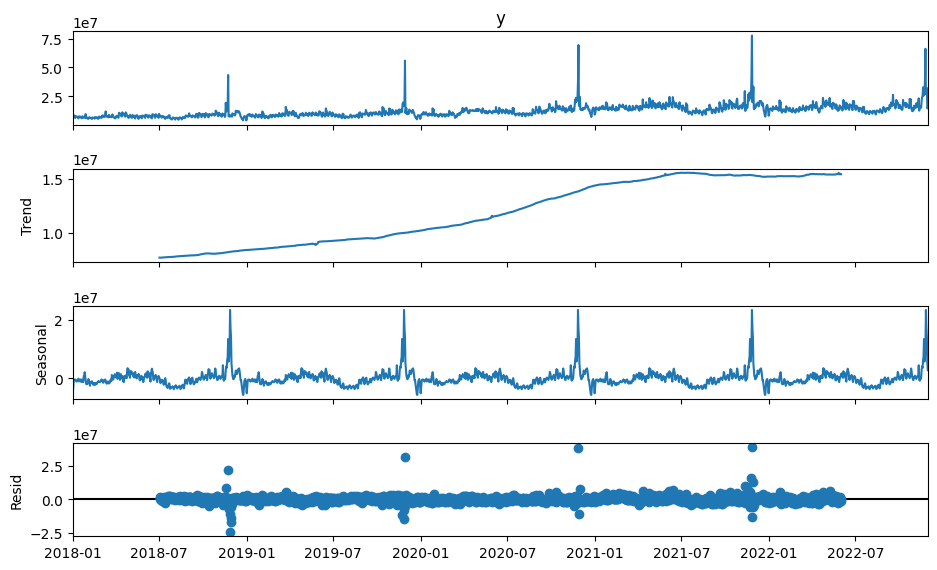

In [13]:
# Seasonal decomponse
decompose = seasonal_decompose(df['y'], model='add', period=365)
fig = decompose.plot()
fig.set_size_inches(10, 6)
plt.show()

# Correlations'


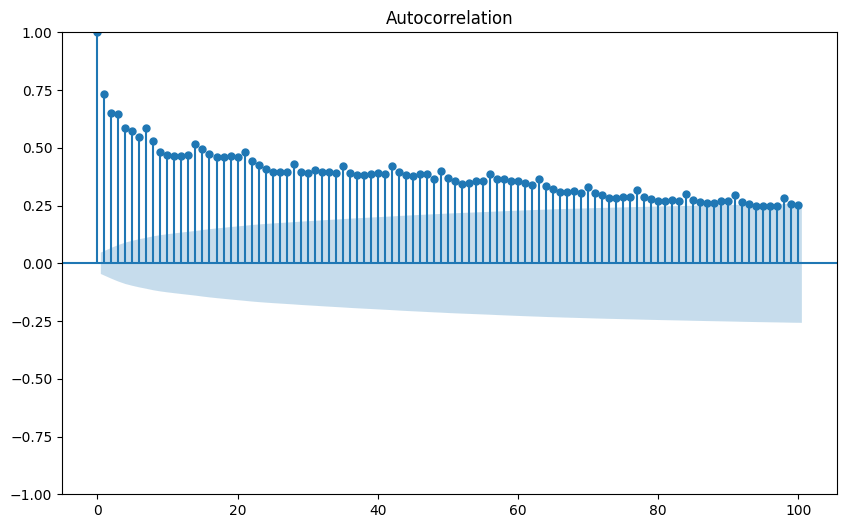

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(df['y'], lags=100, ax=ax)
plt.show()

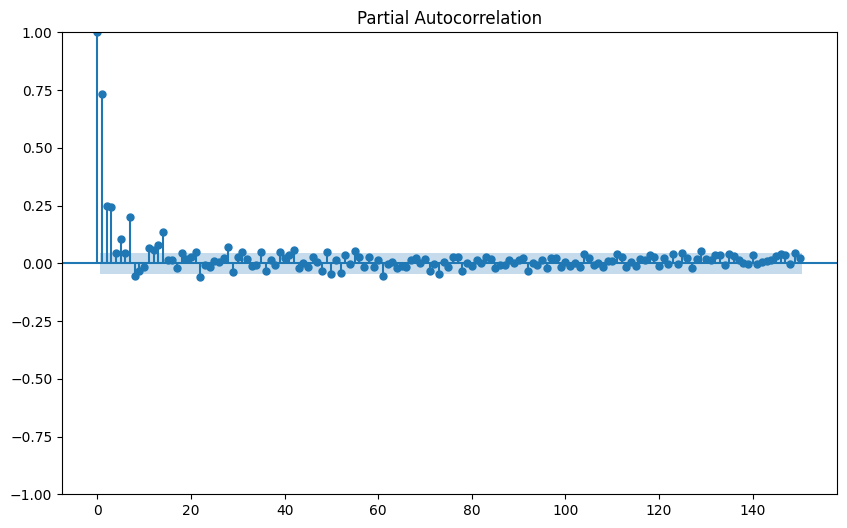

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(df['y'], lags=150, ax=ax)
plt.show()

# Statistical Properties & Stationarity
- Stationarity Test
- Making Data Stationary

In [16]:
# Stationarity test
def check_stationary(y):
    result = adfuller(y)
    '''
    adfuller return 

    [0] - adf : float ->  The test statistic
    [1] - p-value: float  -> MacKinnon's approximate p-value based on MacKinnon
    [2] - usedlag : int  ->  The number of lags used.
    [3] - nobs : int  ->  The number of observations used for the ADF regression and calculation of the critical values.
    [4] - critical values : dict  ->  Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon
    [5] - icbest : float  ->  The maximized information criterion if autolag is not None.
    [6] resstore : ResultStore, optional  -> A dummy class with results attached as attributes.
    '''
    print(f"P-value - {result[1]}")

    if result[1] < 0.05:
        print("Time series is stationary")
    else:
        print("Time series is not stationary")

check_stationary(df['y'])


P-value - 0.10190360862386122
Time series is not stationary


In [1]:
# Making data stationary
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
fig.suptitle('Stationarity Transformations', fontsize=14, fontweight='bold')

# Original
plt.plot(df['y'], label="Original Time", color="red")
plt.title('Original Time Series')
plt.legend()
# 1 First difference
plt.subplot(2, 1, 2)
df['diff_1'] = df['y'].diff().dropna()
plt.plot(df['diff_1'], label="Difference series", color="orange")
plt.title("First Time Difference")
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [18]:
df.head(10)

,y,discount_rate,coupon_rate,diff_1
date,,,,
2018-01-01,6270839.0,34.27%,1.09%,NaN
2018-01-02,8922076.0,30.87%,1.08%,2651237.0
2018-01-03,8446101.0,28.11%,1.01%,-475975.0
2018-01-04,7785798.0,27.32%,0.96%,-660303.0
2018-01-05,6375303.0,25.70%,0.90%,-1410495.0
2018-01-06,6095418.0,25.02%,0.87%,-279885.0
2018-01-07,7661844.0,25.33%,1.06%,1566426.0
2018-01-08,7036112.0,24.83%,1.03%,-625732.0
2018-01-09,7100900.0,25.11%,1.00%,64788.0


In [19]:
check_stationary(df['diff_1'].dropna())

P-value - 6.513792026814802e-24
Time series is stationary


# ARIMA model


# Train, Test and Forecast

In [20]:
periods = 30
train, test = df.iloc[:-periods], df.iloc[-periods:]
train.head(10)

,y,discount_rate,coupon_rate,diff_1
date,,,,
2018-01-01,6270839.0,34.27%,1.09%,NaN
2018-01-02,8922076.0,30.87%,1.08%,2651237.0
2018-01-03,8446101.0,28.11%,1.01%,-475975.0
2018-01-04,7785798.0,27.32%,0.96%,-660303.0
2018-01-05,6375303.0,25.70%,0.90%,-1410495.0
2018-01-06,6095418.0,25.02%,0.87%,-279885.0
2018-01-07,7661844.0,25.33%,1.06%,1566426.0
2018-01-08,7036112.0,24.83%,1.03%,-625732.0
2018-01-09,7100900.0,25.11%,1.00%,64788.0


In [21]:
# USing pmdarima fot the best model and the best parameters
model = auto_arima(train['y'], seasonal=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1765
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -28817.267
Date:                Sun, 11 Jan 2026   AIC                          57650.535
Time:                        17:29:36   BIC                          57694.337
Sample:                    01-01-2018   HQIC                         57666.720
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.120     -3.449      0.001      -0.649      -0.179
ar.L2          0.3017      0.053      5.671      0.000       0.197       0.406
ar.L3          0.1570      0.028      5.705      0.000       0.103       0.211
ar.L4          0.0679      0.029      2.365      0.018       0.012       0.124
ar.L5          0.0466      0.024      1.937      0.053      -0.001       0.094
ma.L1         -0.1598      0.118     -1.354      0.176      -0.391       0.071
ma.L2         -0.7423      0.108     -6.872      0.000      -0.954      -0.531
sigma2      9.084e+12   1.86e-14   4.88e+26      0.000    9.08e+12    9.08e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            580903.26
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             5.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.93e+42. Standard errors may be unstable.
"""

In [22]:
# Prediction
prediction_model = model.predict(n_periods=len(test))
prediction_model

2022-11-01    1.445299e+07
2022-11-02    1.474103e+07
2022-11-03    1.503283e+07
2022-11-04    1.527520e+07
2022-11-05    1.534078e+07
2022-11-06    1.553442e+07
2022-11-07    1.554542e+07
2022-11-08    1.563967e+07
2022-11-09    1.565016e+07
2022-11-10    1.569221e+07
2022-11-11    1.570256e+07
2022-11-12    1.571953e+07
2022-11-13    1.572734e+07
2022-11-14    1.573420e+07
2022-11-15    1.573904e+07
2022-11-16    1.574197e+07
2022-11-17    1.574462e+07
2022-11-18    1.574600e+07
2022-11-19    1.574734e+07
2022-11-20    1.574804e+07
2022-11-21    1.574869e+07
2022-11-22    1.574906e+07
2022-11-23    1.574937e+07
2022-11-24    1.574956e+07
2022-11-25    1.574971e+07
2022-11-26    1.574981e+07
2022-11-27    1.574988e+07
2022-11-28    1.574994e+07
2022-11-29    1.574997e+07
2022-11-30    1.575000e+07
Freq: D, dtype: float64

In [23]:
def model_assessment(train, test, prediction, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train, label="train")
    plt.plot(test, label="Test")
    plt.plot(prediction, label="Forecast")
    plt.legend()
    plt.title(f"Train, test and forecast with {title}")

    mae = mean_absolute_error(test, prediction)
    rmse = root_mean_squared_error(test, prediction)
    mape = mean_absolute_percentage_error(test, prediction)

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {100 * mape:.2f}%")

MAE: 7267306.03
RMSE: 12366038.30
MAPE: 24.15%


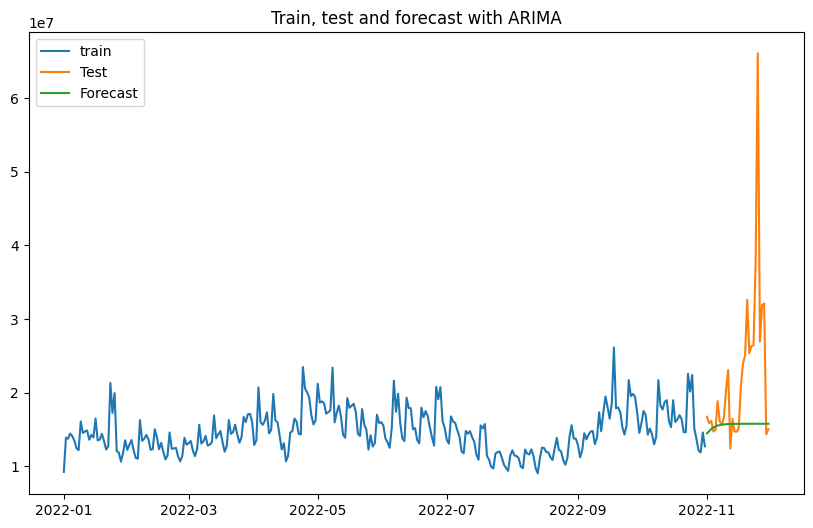

In [24]:
model_assessment(train['y']['2022':], test['y'], prediction_model, "ARIMA")

# SARIMA

In [ ]:
df.columns

In [ ]:
# Transform regressors into float
df['discount_rate'] = df['discount_rate'].str.replace('%', '').astype('float')
df['coupon_rate'] = df['coupon_rate'].str.replace('%', '').astype('float')


In [ ]:

df.info()

In [ ]:
# regressor Train and test
periods = 30
s_train, s_test = df.iloc[:-periods, 1:3], df.iloc[-periods: , 1:3]
s_train.head()

In [ ]:
# Using pmdarima for the sarimax model
model_sarimax = auto_arima(train['y'], m=7, X=s_train)
model_sarimax.summary()

In [ ]:
# prediction
prediction_sarimax = model_sarimax.predict(n_periods=len(test), X=s_test)
prediction_sarimax

In [ ]:
# Model assessment
model_assessment(train['y']['2022':], test['y'], prediction_sarimax, "SARIMAX")

# Cross Validation

In [ ]:
# define the model to do cv
model_cv = ARIMA( order=(2, 1, 2), seasonal_order=(2, 0, 2, 7))

In [ ]:
# set the cross validation rules
cv = model_selection.RollingForecastCV(h=30, step=15, initial=df.shape[0] - 180)

In [ ]:
# inputs for the cross validation
cv_score = model_selection.cross_val_score(model_cv , 
                                           y=df['y'], 
                                           X=df.iloc[:, 1:3], 
                                           scoring='mean_squared_error',
                                           cv=cv,
                                           verbose=1,
                                           error_score=10000000000
                                           )

In [ ]:
# CV performance
rmse = np.sqrt(np.average(cv_score))
print(f"RMSE: {int(rmse)}")

# Parameter tunning

In [ ]:
# Defining the parameter
param_grid = {
    'p': [1, 2, 3],
    'd': [0, 1],
    'q': [1, 2, 3],
    'P': [1, 2],
    'D': [0],
    'Q': [1, 2]
}

grid = ParameterGrid(param_grid)
list(grid)

In [ ]:
# paramter tuning loop
rmse_list = []

for params in grid:

    # Build a model with set of parameters
    model_cv = ARIMA( order=(
        params['p'], params['d'], params['q']), 
        seasonal_order=(params['P'], params['D'], params['Q'], 7)
        )

    # Evaluate the model
    cv = model_selection.RollingForecastCV(h=30, step=15, initial=df.shape[0] - 180)
    # Input the cv
    cv_score = model_selection.cross_val_score(model_cv , 
                                            y=df['y'], 
                                            X=df.iloc[:, 1:3], 
                                            scoring='mean_squared_error',
                                            cv=cv,
                                            verbose=1,
                                            error_score=10000000000
                                            )

    # Store the error
    rmse = np.sqrt(np.average(cv_score))
    rmse_list.append(rmse)

In [ ]:
#checking result
tuning_result = pd.DataFrame(grid)
tuning_result['rmse'] = rmse_list
tuning_result

In [ ]:
# save the best parameters
best_params = tuning_result[tuning_result['rmse'] == tuning_result['rmse'].min()].transpose()

In [ ]:
# Predicting future
y = df['y']
X = df.iloc[:, 1:3]


In [ ]:
# fetch the best parameters
p = int(best_params.loc['p'])
d = int(best_params.loc['d'])
q = int(best_params.loc['q'])
P = int(best_params.loc['P'])
D = int(best_params.loc['D'])
Q = int(best_params.loc['Q'])

In [ ]:
reg_path = "/home/mano/Manoj/Learning/time_series/data/time-series-analysis/Time Series Analysis/ARIMA, SARIMA and SARIMAX/future_regressors.csv"

In [ ]:
df_future = pd.read_csv(reg_path, index_col='date', parse_dates=True, dayfirst=True)
df_future.head(10)

In [ ]:
X_future = df_future.iloc[:, 1:3] * 100

In [ ]:
# Tuned sarimax model
tuned_model = ARIMA(order=(p,d,q), seasonal_order=(P,D,Q,7))
tuned_model.fit(y, X = X)

In [ ]:
# forecast
predictions = tuned_model.predict(n_periods=len(X_future), X=X_future)

In [ ]:

def plot_future(y, forecast):
    plt.figure(figsize=(10, 6))
    plt.plot(y, label="Train")
    plt.plot(forecast, label="Forecast")
    plt.legend()
    plt.show()


In [ ]:
plot_future(y['2022':], predictions)